Module importing

In [1]:
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.signal as signal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

sys.path.append('/workspace/my_DL_tool/model')
from unet_base import UNet1D
sys.path.append('/workspace/my_DL_tool/tool')
from model_builder import k_fold_training
from performance import performance
sys.path.append('/workspace/my_DL_tool/tool/data_load')
from ppg_labeled_load import PPGDataset

Data prepairing

(1024,)


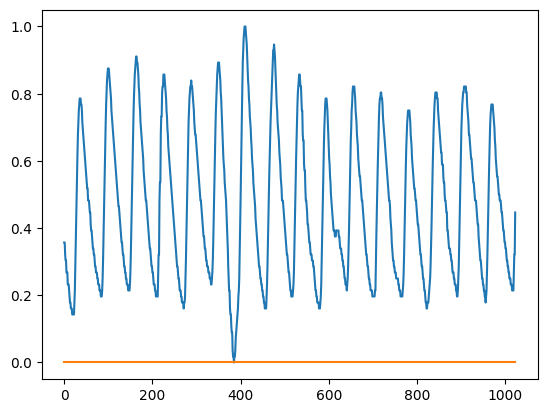

153
769


In [2]:
#Import_data
def preprocessing1(item):
    N = 200
    item[0] = signal.resample(item[0],N)
    item[1] = signal.resample(item[1],N)
    item[0] = (item[0]-np.min(item[0]))/(np.max(item[0])-np.min(item[0]))
    item[1] = (item[1]-np.min(item[1]))/(np.max(item[1])-np.min(item[1]))
    if len(item[0]) == len(item[1]):
        return item

def preprocessing2(item):
    N = 1000
    if len(item[0]) != 1024:
        item[0] = item[0][0:1024]
        item[0] = (item[0]-np.min(item[0]))/(np.max(item[0])-np.min(item[0]))
    if len(item[1]) != 1024:
        item[1] = item[1][0:1024]    
        item[1] = (item[1]-np.min(item[1]))/(np.max(item[1])-np.min(item[1]))
    item1 = [item[1],item[0]]
    return item

dataset = PPGDataset('/workspace/my_DL_tool/data/packaged_data')
index = random.randint(0, len(dataset)-1)
z = dataset[0][0].numpy().flatten()
print(z.shape)
plt.plot(dataset[0][0].numpy().flatten())
plt.plot(dataset[0][1].numpy().flatten())
plt.show()

N = len(dataset)
test_len = int(N*0.2)
train_len = N-test_len

train_data, test_data = random_split(dataset, [train_len, test_len])
print(len(test_data))
print(len(dataset))

Training

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = UNet1D()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
builder = k_fold_training(train_data,1,criterion = nn.L1Loss())
builder.training(model,device,optimizer,num_epochs=300,batch=512,visualize=1)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
Iteration: 1/300. loss_train: 0.35439109802246094. loss_val: 0
Iteration: 2/300. loss_train: 0.3037799447774887. loss_val: 0
Iteration: 3/300. loss_train: 0.2861189618706703. loss_val: 0
Iteration: 4/300. loss_train: 0.3082578182220459. loss_val: 0
Iteration: 5/300. loss_train: 0.2694576531648636. loss_val: 0
Iteration: 6/300. loss_train: 0.2893393337726593. loss_val: 0
Iteration: 7/300. loss_train: 0.28955601155757904. loss_val: 0
Iteration: 8/300. loss_train: 0.2743995264172554. loss_val: 0
Iteration: 9/300. loss_train: 0.2825546860694885. loss_val: 0
Iteration: 10/300. loss_train: 0.30141615867614746. loss_val: 0
Iteration: 11/300. loss_train: 0.27756790816783905. loss_val: 0
Iteration: 12/300. loss_train: 0.243420772254467. loss_val: 0
Iteration: 13/300. loss_train: 0.2974552512168884. loss_val: 0
Iteration: 14/300. loss_train: 0.2634180784225464. loss_val: 0
Iteration: 15/300. loss_train: 0.2484280914068222. loss_val: 0
Iteration: 16/300. loss_train: 0.26555581390857697. loss

Performance

Max loss:  1.4439458
Mean loss:  0.11438492
Min loss:  0.008465604
Number of test:  153


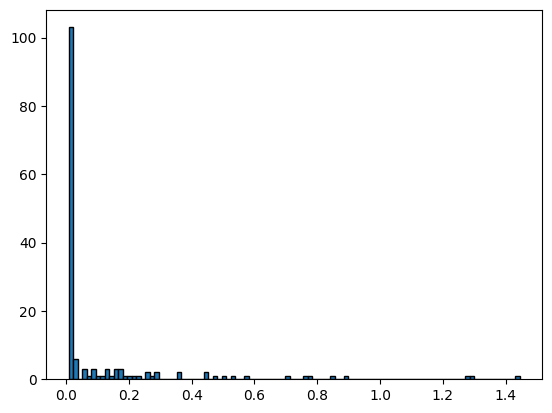

0.010405175


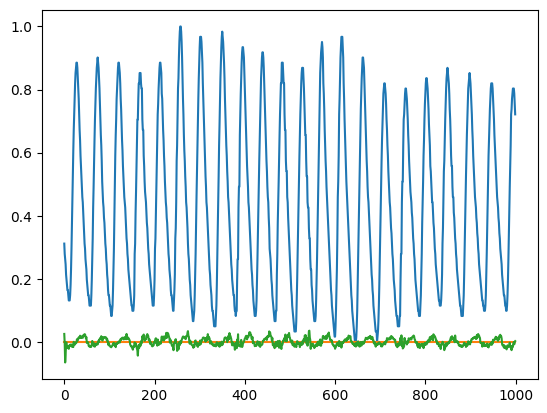

0.010013872


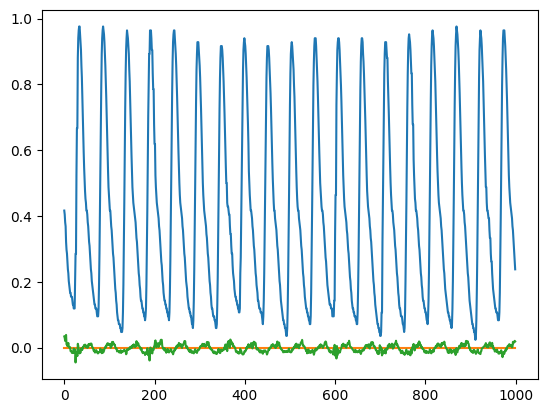

0.012313651


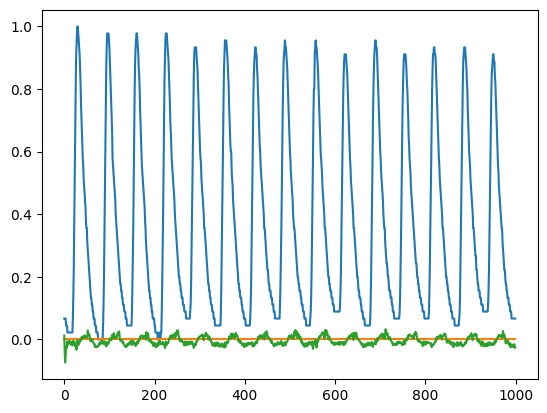

0.009159001


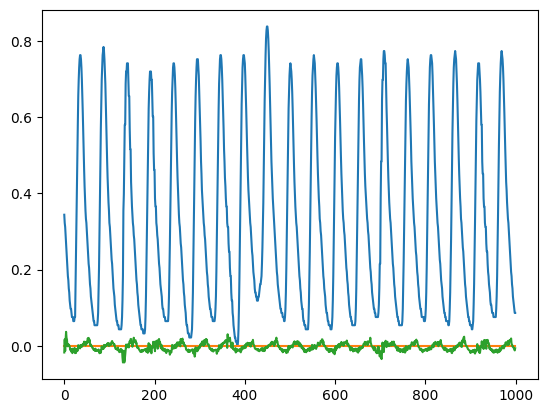

0.84195125


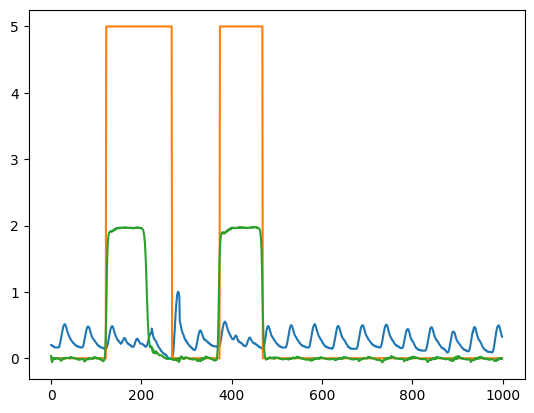

0.010476032


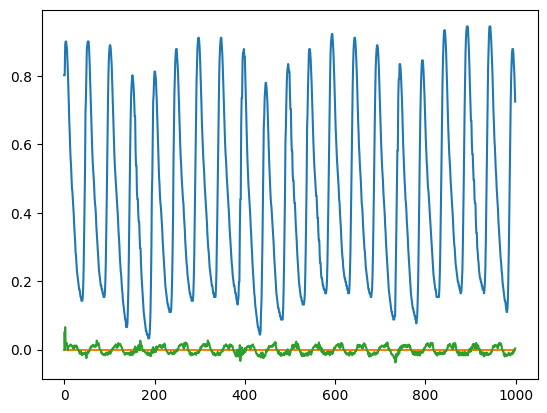

0.011254955


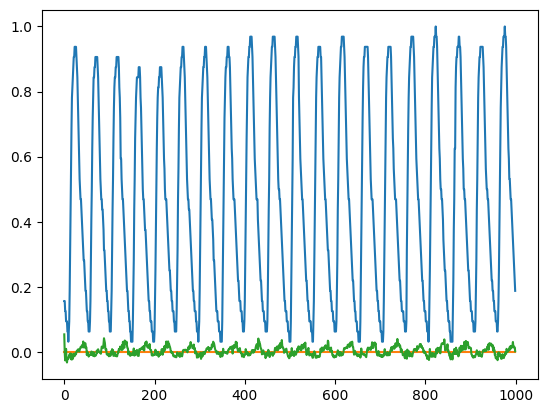

0.15878707


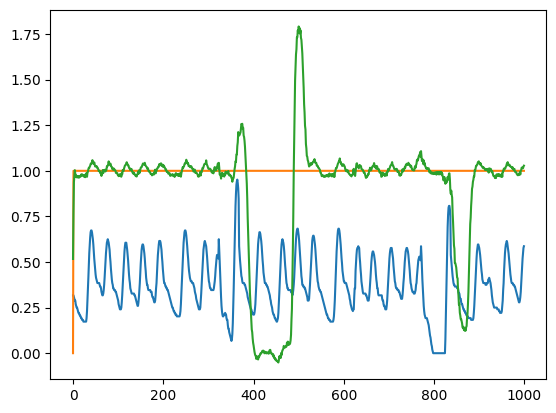

0.0093072


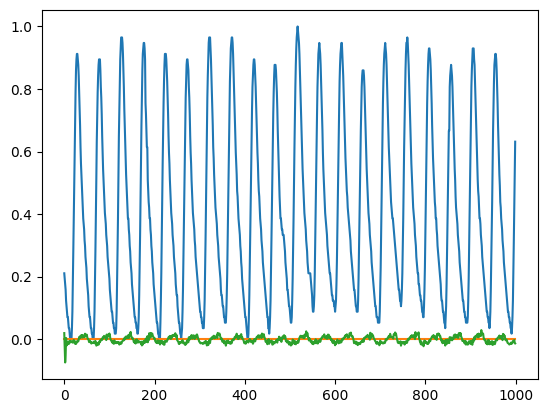

0.012707388


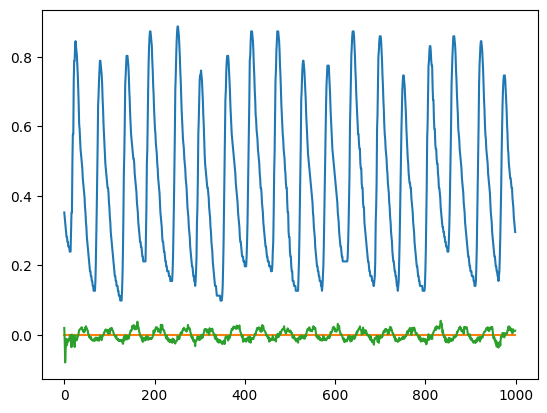

0.012498898


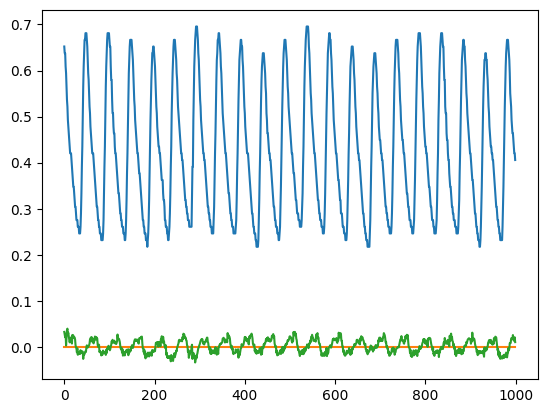

0.0093828365


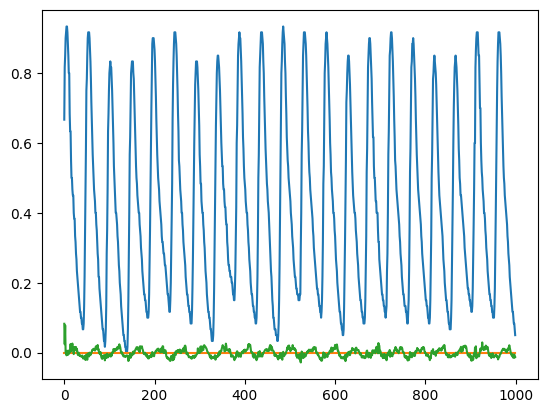

0.00987264


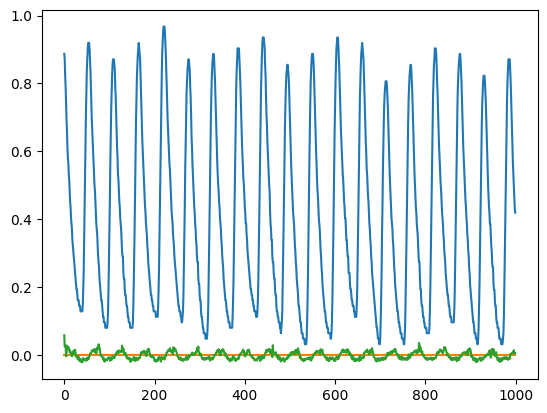

0.009396026


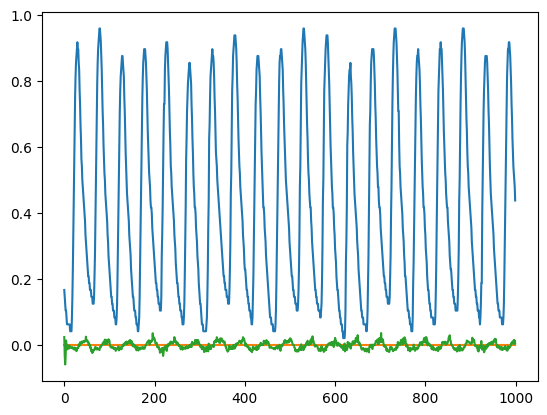

0.009845909


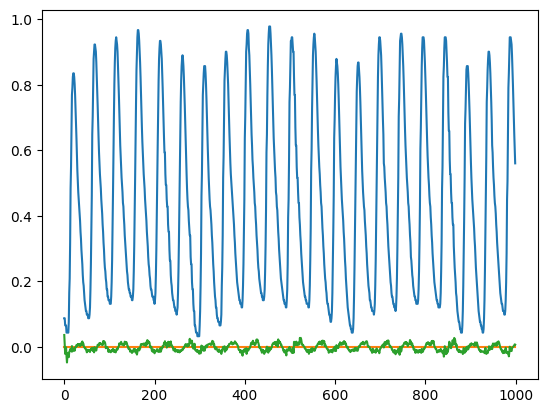

0.011792489


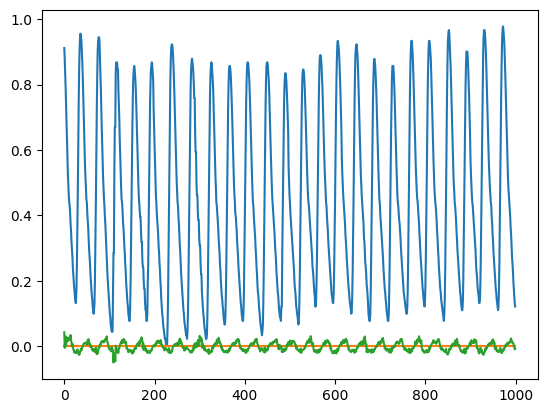

0.011460672


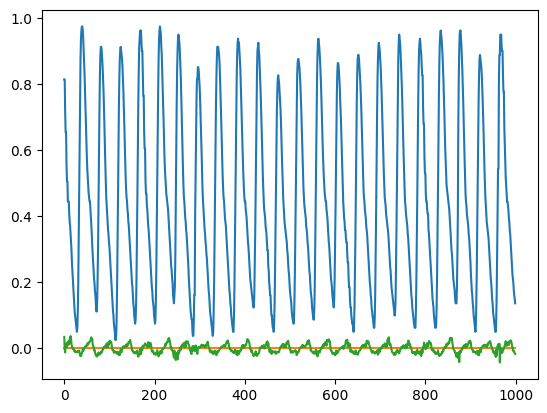

0.36130983


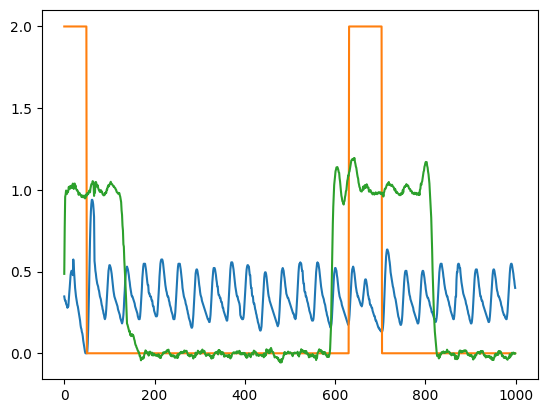

0.008465604


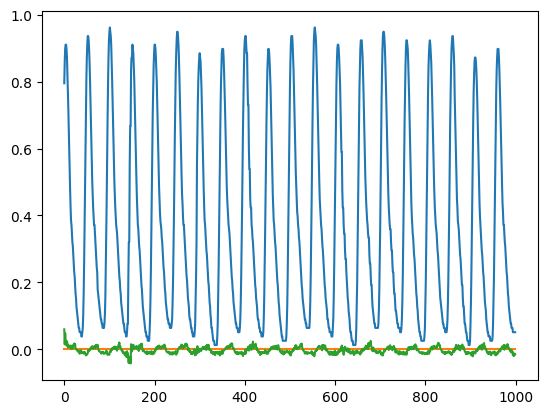

0.010922682


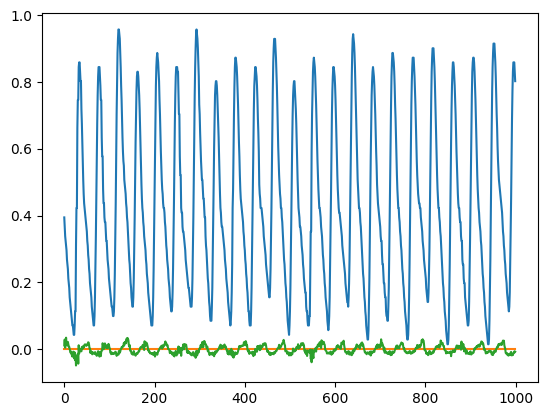

0.012016023


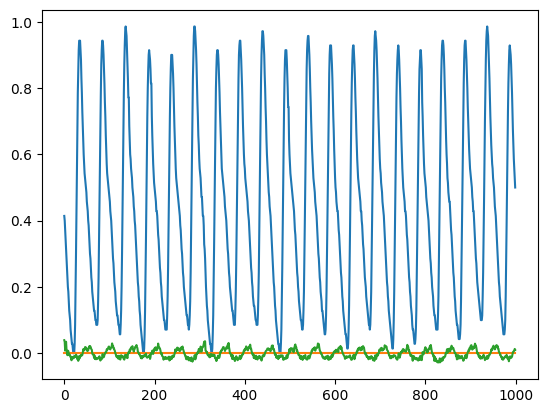

0.29401085


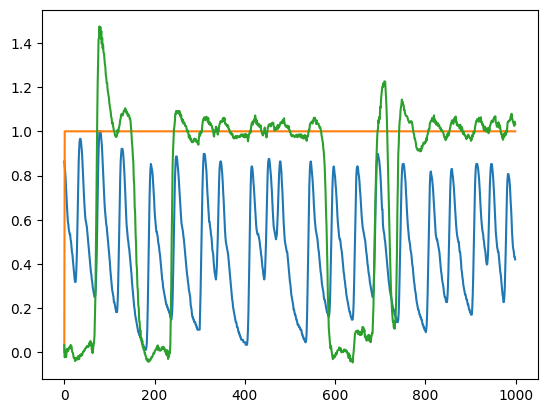

0.011485339


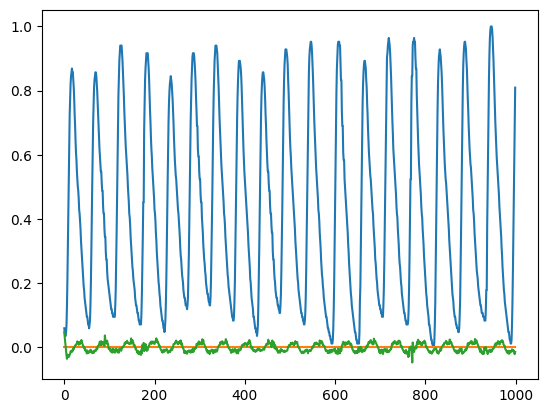

0.010546401


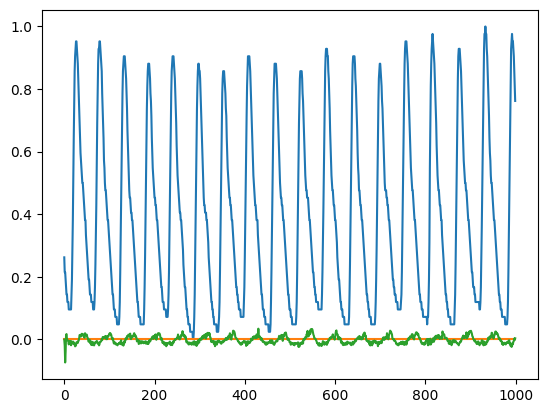

0.010833515


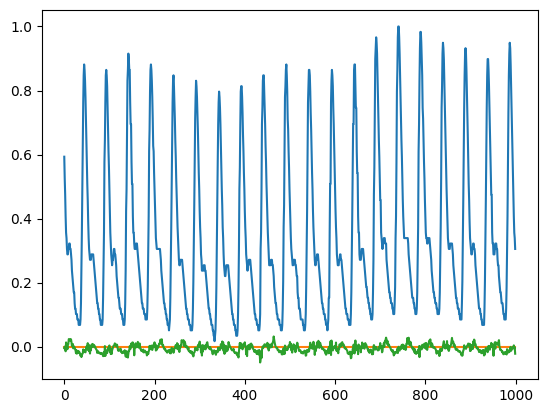

0.011455853


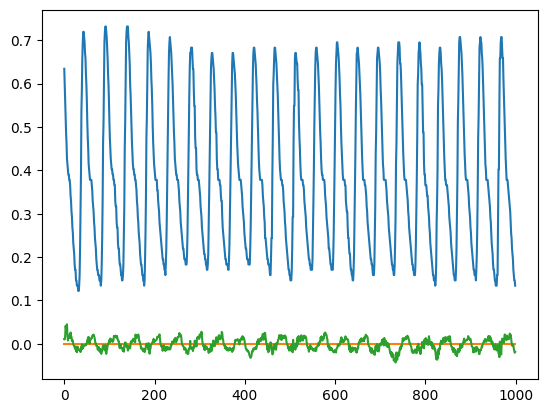

0.01152554


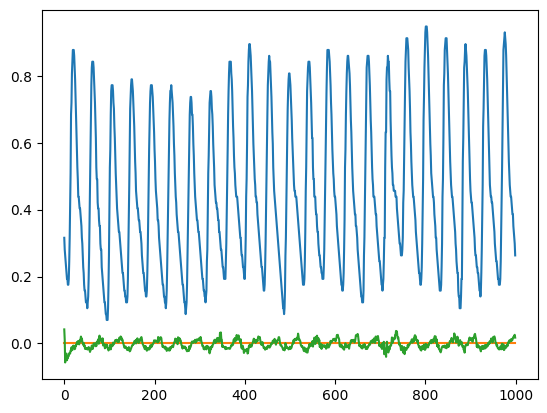

0.023867454


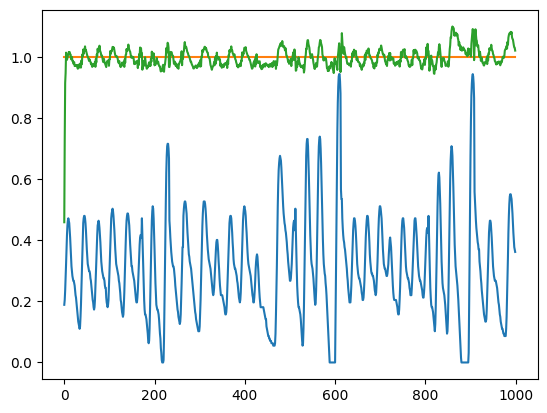

1.4439458


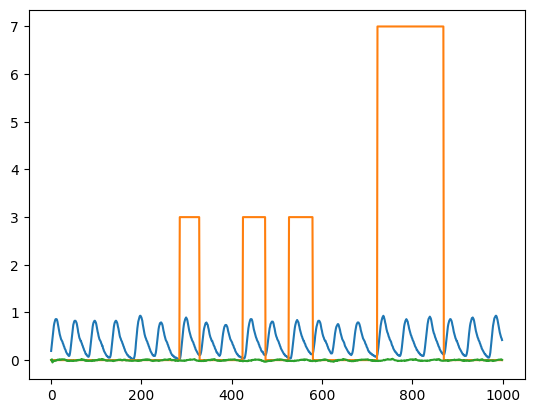

0.18418102


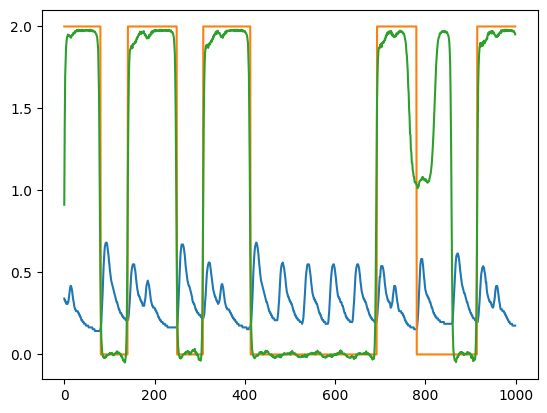

0.008769996


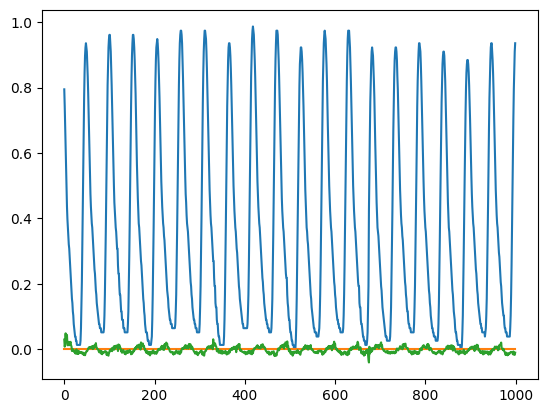

0.011262469


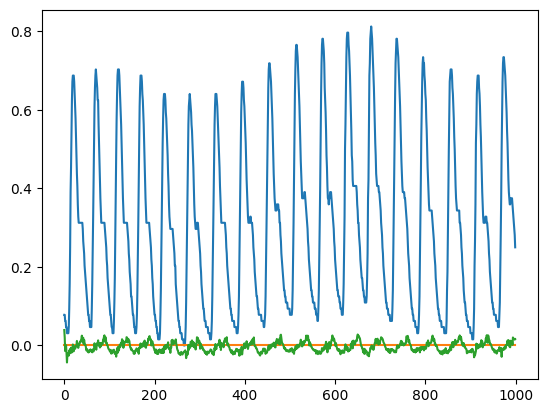

0.026056007


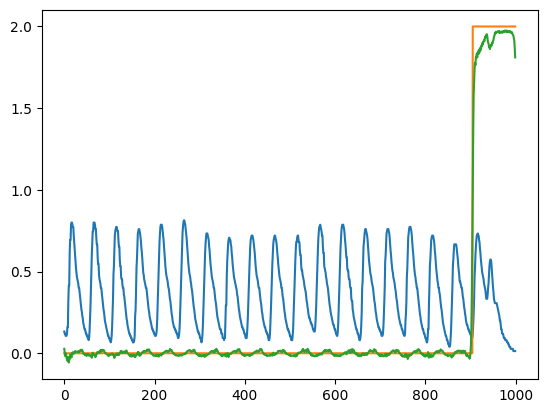

0.890926


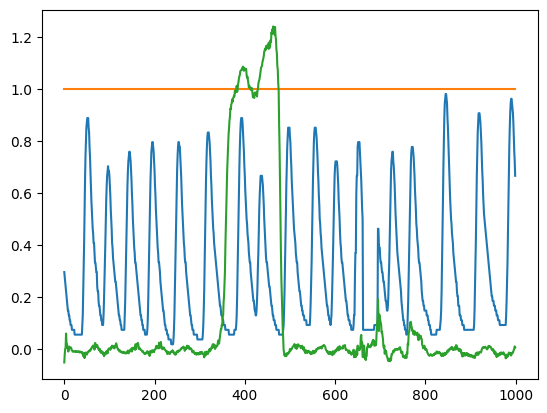

0.012157854


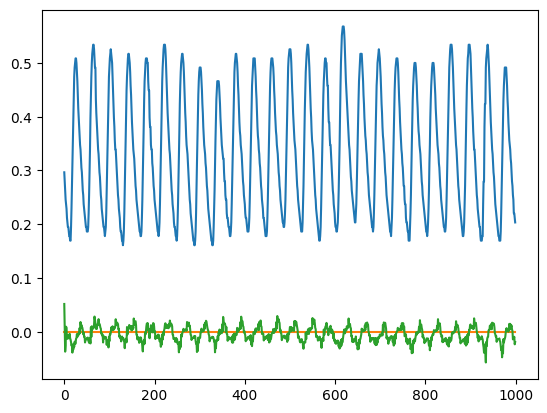

0.15432243


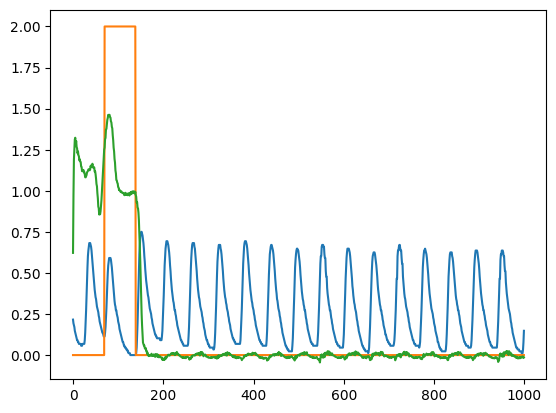

0.08756665


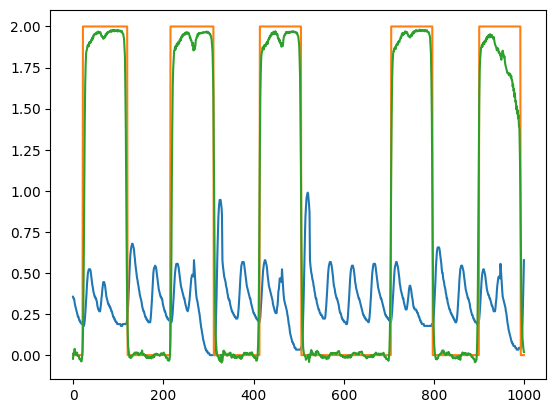

0.009625997


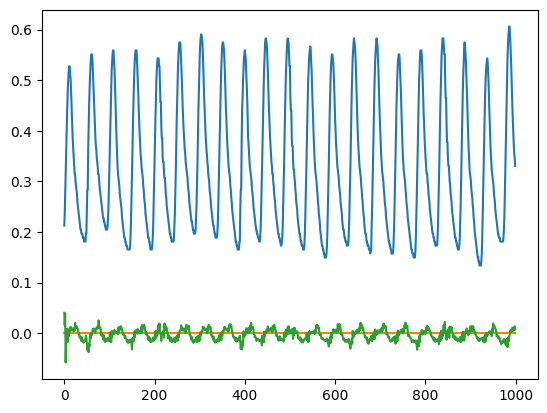

0.0177727


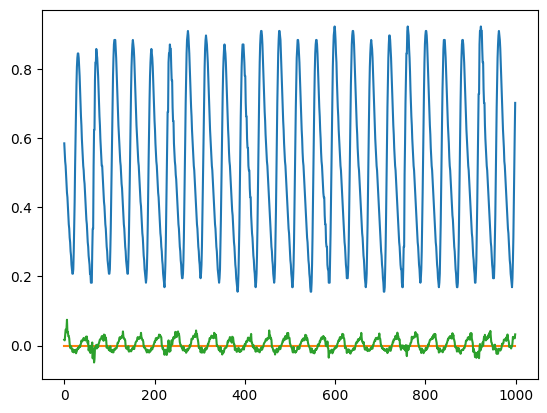

0.012398291


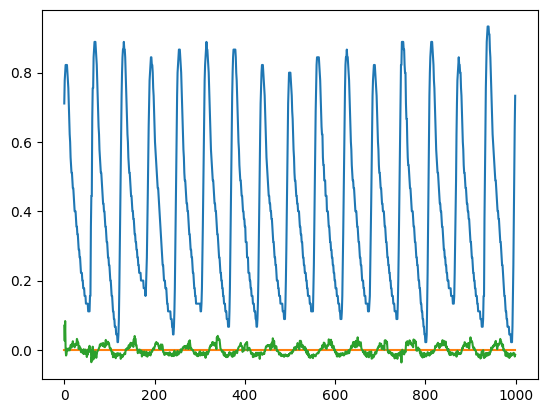

0.017062694


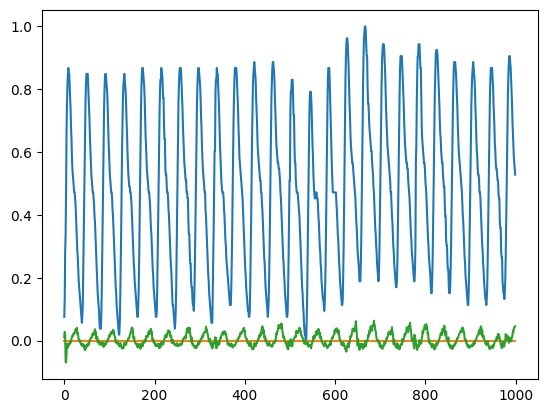

0.01177329


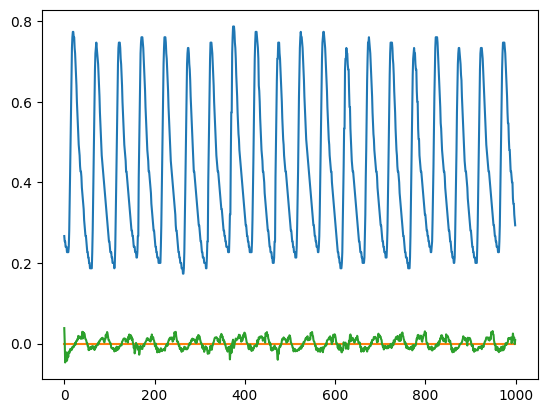

0.014257887


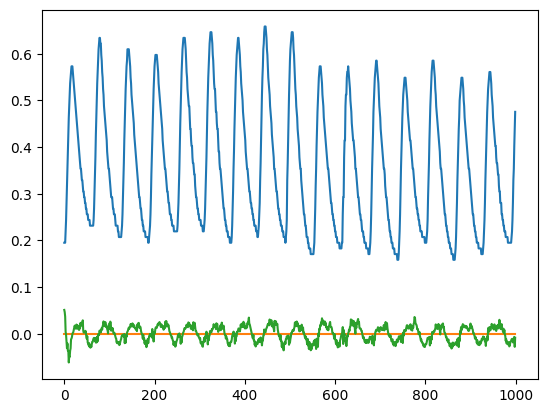

0.0612296


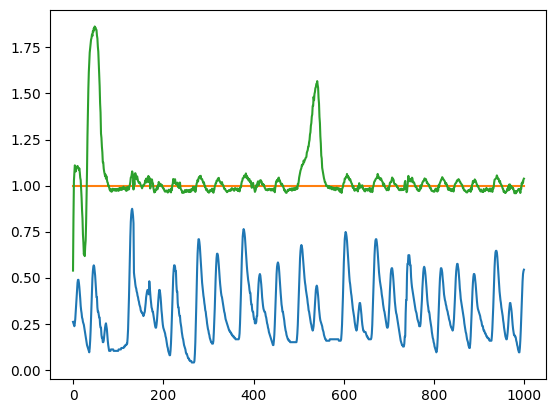

0.010739356


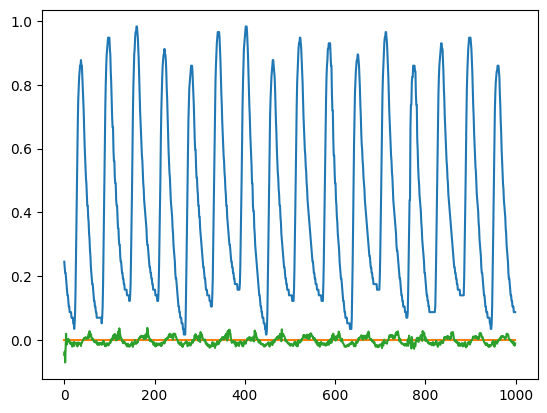

0.25848198


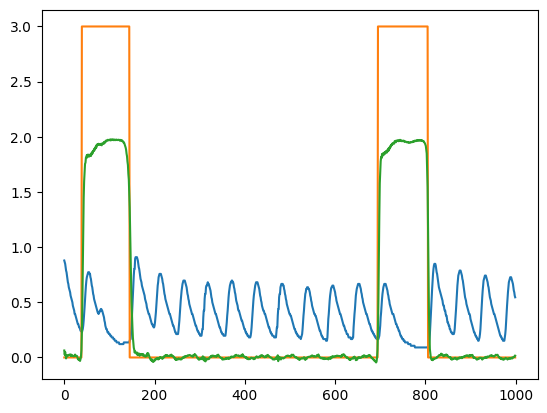

0.011761707


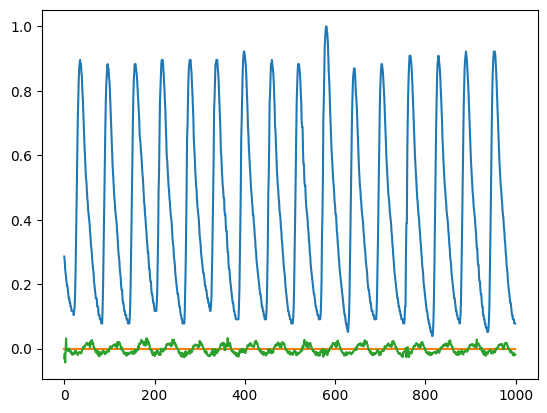

0.010478076


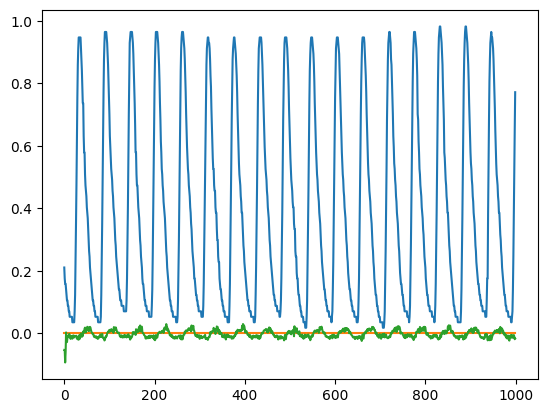

0.011093626


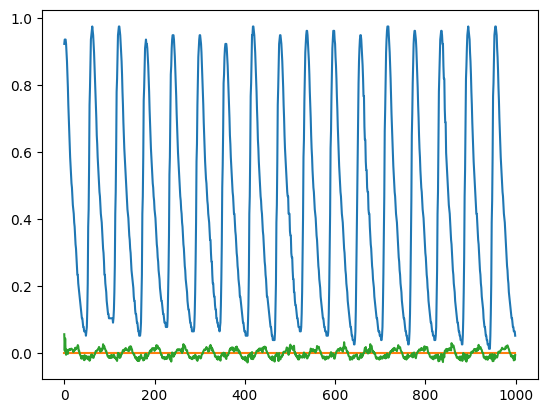

0.082860716


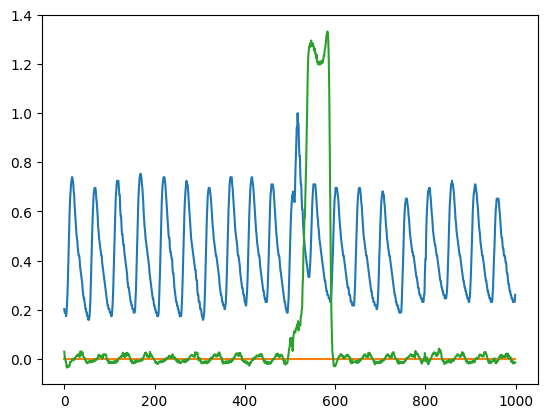

In [5]:
shower = performance()
shower.test(model,device,test_data,per_fnc = "series")
criterion = nn.L1Loss()
for i in range(50):
    output = torch.stack([test_data[i][1]]).to(device)
    input = torch.stack([test_data[i][0]]).to(device)
    y_hat = model.forward(input)
    loss = criterion(y_hat,output)
    
    print(loss.cpu().detach().numpy())
    plt.plot(input.cpu().detach().numpy().flatten()[0:1000])
    plt.plot(output.cpu().detach().numpy().flatten()[0:1000])
    plt.plot(y_hat.cpu().detach().numpy().flatten()[0:1000])
    plt.show()